In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import napari
from napari_video.napari_video import VideoReaderNP

In [3]:
vdos = []

In [6]:
vdos

[]

In [5]:
!git clone https://github.com/Hzzone/pytorch-openpose
%cd pytorch-openpose
import matplotlib.pyplot as plt
import copy
import numpy as np
from src import model
from src import util
from src.body import Body
from src.hand import Hand

!cp /kaggle/input/openpose-pretrained-models/body_pose_model.pth model
!cp /kaggle/input/openpose-pretrained-models/hand_pose_model.pth model

body_estimation = Body('model/body_pose_model.pth')
hand_estimation = Hand('model/hand_pose_model.pth')

Cloning into 'pytorch-openpose'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 154 (delta 69), reused 152 (delta 67), pack-reused 0
Receiving objects: 100% (154/154), 20.18 MiB | 9.83 MiB/s, done.
Resolving deltas: 100% (69/69), done.
/kaggle/working/pytorch-openpose/pytorch-openpose


In [ ]:
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_2987.MOV'))


In [31]:
labels = ['Bird','Black','Car','Dog','Fall','Father','Good Morning', 'Red','Summer','White','loud','quiet','happy','long','short','big large', 'small little','hot', 'new','dry','good','Cow','Hat', 'T-Shirt', 'Shoes', 'Monday', 'Year', 'Time', 'Fan', 'Cell phone', 'Hello', 'Thank you', 'Window', 'Pen', 'Paint', 'Teacher', 'Priest', 'train ticket', 'Brother', 'Boy', ' Girl', ' Bank', 'I', 'it','you', 'Election', 'Death', 'Court', 'House', 'Store or Shop']

In [44]:
lines = [24,15,16,13,12,18,17,18,11,19,15,18,18,15,16,17,18,15,18,21,18,18,14,17,16,12,8,12,12,10,14,14,11,12,12,11,14,14,16,17,18,16,18,12,18,12,9,20,20,18]

In [32]:
len(labels)

50

In [7]:
vdos

[]

In [47]:
y = []

In [48]:
for i in range(49):
    for j in range(1,lines[i]):
        y.append(i)

In [49]:
len(y)

700

In [ ]:
#TRAIN IN INCLUDE KAGGLE

vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_2987.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_3094.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_3095.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_8567.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_3040.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_3096.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_3037.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_3013.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_3012.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_3038.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/Extra/MVI_3045.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/Extra/MVI_3044.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/Extra/MVI_3043.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/Extra/MVI_3042.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/Extra/MVI_3041.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_3011.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_4155.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_4157.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_4156.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_3070.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_8568.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_3071.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_3072.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_2989.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_4919.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_4918.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_5208.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_3889.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_3888.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_3741.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_4039.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_4215.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_5059.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_5058.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_5060.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_3887.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_5206.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_8619.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/54. Black/MVI_4040.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3118.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3240.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3146.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3147.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3209.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_4176.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_4177.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3211.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3239.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3238.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3210.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_4178.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3175.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_8583.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_8584.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3117.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_2979.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_8561.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_3085.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_3030.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_4148.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_4146.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_3004.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_3028.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_3002.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_3003.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_3059.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_3061.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_3060.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_5434.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_9133.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_5436.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_5433.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_9135.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_9134.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_4577.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_4580.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_4999.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_4579.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_5000.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_5001.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_3910.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_5227.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_3912.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_4062.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_4061.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_4060.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_4940.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_4941.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_5081.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_4942.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_3763.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_4223.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_3764.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_3765.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_5229.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_5228.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_8626.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_3909.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_9970.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_0048.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_0100.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_0099.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_0098.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_0042.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_9933.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_9932.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_0043.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_0044.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_9935.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_9934.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_0045.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_0047.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_0046.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_9991.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_9968.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_3720.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_5184.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_3867.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_3866.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_5185.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_3721.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_3719.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_5037.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_4897.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_8612.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_4207.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_4017.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_4019.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_4018.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_5039.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_5038.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_4899.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_3868.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_5420.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_9124.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_5421.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_5422.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_9123.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_5424.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_4990.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_4992.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_4565.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_4566.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_4567.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_4923.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_5209.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_4922.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_4921.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_3743.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_4216.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_3745.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_3744.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_5061.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_5063.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_5062.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_3892.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_4044.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_8620.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_5210.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_3891.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_3890.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_4043.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_2of2/Colours/55. White/MVI_4042.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5178.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5179.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9368.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9534.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9291.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9290.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9535.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5337.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5257.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9450.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5336.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5335.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9449.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9448.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9370.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_5340.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_5181.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_5182.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9537.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9292.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9293.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9294.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9451.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9452.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9453.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_5338.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_5339.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9538.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_5262.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_5261.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_5260.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9373.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9371.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9540.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9541.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_5184.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_5185.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9542.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_5341.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_5343.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_5342.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9456.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9454.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9455.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9295.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9296.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_5264.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_5265.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9375.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9374.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9376.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_5187.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_5186.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_9378.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_9218.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_5108.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_5107.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_9298.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_5267.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_9460.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_5266.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_9299.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_9458.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_9459.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_5188.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_9217.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_5190.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_9382.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_9221.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_9380.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_9381.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_5269.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_5112.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_5270.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_9463.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_5111.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_9461.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_5110.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/extra/MVI_5192.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_9302.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_9301.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_5189.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_9233.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_9234.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_9396.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_9235.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_9394.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_9318.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_5124.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_5285.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_5284.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_5125.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_5123.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_9476.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_9477.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_9316.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_9317.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_5204.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_5205.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_5208.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_9237.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_9236.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_9319.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_5286.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_9480.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_5287.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_5126.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_9479.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_9478.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_9321.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/extra/MVI_5209.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_5128.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_5288.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_5207.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_9398.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_9400.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_9238.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_9409.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_5218.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_9330.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_9247.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_5295.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_5136.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_5297.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_5296.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_5137.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_9488.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_5138.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_9249.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_9328.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_9410.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_5217.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_9421.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_5151.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_5231.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_9423.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_9422.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_9340.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_9341.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_9342.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_5308.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_5309.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_9502.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_9259.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_5307.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_9500.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_9261.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_9260.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_5229.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_5148.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_5169.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_5168.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_9279.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_9523.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_5250.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_9522.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_9278.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_5326.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_9440.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_9441.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_9521.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_5327.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_9277.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_5249.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_5248.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_5328.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_9359.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_5167.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_9361.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_9360.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_8of8/Adjectives/97. dry/MVI_9439.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_9351.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_9350.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_9432.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_9431.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_5318.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_9268.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_5240.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_9269.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_9270.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_9510.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_5316.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_5317.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_9511.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_9512.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_5159.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_5238.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_9349.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_5160.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_2992.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3046.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_2990.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_2991.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3047.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3097.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_8570.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_4158.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_4159.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_4160.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3015.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3017.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_8569.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3098.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3099.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3049.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3075.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3074.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_3691.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_3690.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_5008.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_5154.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_3985.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_3986.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_4197.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_3835.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_3837.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_3688.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_5006.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_4867.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_4866.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_5007.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_5022.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_4881.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_5023.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_5169.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_5021.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_4883.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_4882.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_8606.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_4202.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_4002.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_4003.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_5171.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_3851.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_3850.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_5170.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_3705.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_3706.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_5030.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_4887.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_4204.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_4008.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_4009.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_8608.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_3710.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_5177.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_3857.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_3856.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_4888.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_5176.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_3711.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_5028.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_5175.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_3712.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_5009.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_9144.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_5446.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_9142.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_9143.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_4594.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_5449.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_5448.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_4592.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_4591.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_5011.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_5010.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_5047.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_9178.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_5492.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_5493.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_5491.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_5048.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_9175.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_9176.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_4670.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_4667.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_5078.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_5079.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_5524.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_5526.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_9204.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_9202.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_9203.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_9201.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_4668.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_4669.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_5390.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_9097.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_4966.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_4964.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_4965.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_4534.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_4536.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_9099.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_9098.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_4533.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_4532.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_5389.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_5391.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_5392.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_5394.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_4539.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_4538.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_4968.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_4540.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_9102.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_9100.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_9101.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_0039.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_0038.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_0089.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_9914.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_9917.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_9916.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_0090.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_9984.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_0037.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_9956.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_0032.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_9955.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_9954.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_9983.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0007.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_9949.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0063.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0062.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0060.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0061.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0059.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0111.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0058.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0112.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_9950.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_9986.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0008.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_9985.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_4881.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_8767.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_4883.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_4882.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_8766.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_4365.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_4364.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_4362.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_9013.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_9014.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_8769.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_4908.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_9033.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_9032.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_4388.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_9034.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_4389.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_4387.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_4390.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_8794.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_8795.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_4907.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_8791.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_8819.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_9051.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_8818.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_4926.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_9053.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_9052.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_4927.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_8820.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_4414.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_4412.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_4413.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_4928.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_4459.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_4458.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_5310.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_8866.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_5311.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_8864.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_8865.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_5312.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_4746.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_4745.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_4744.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_5345.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_4488.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_4489.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_5344.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_5343.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_5342.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_8887.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_4770.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_4771.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_8889.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_8888.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_4490.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_4487.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_4486.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3133.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3255.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3254.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3134.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3224.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3226.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3196.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3194.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_4191.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3164.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_4192.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3162.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_8596.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_4076.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_4075.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_3928.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_5245.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_5244.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_3780.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_3781.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_5096.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_5243.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_4955.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_4957.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_5095.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_4956.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_3778.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_4230.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_8631.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_4110.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_4112.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_5133.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_5286.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_5132.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_3964.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_5285.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_4983.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_3815.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_3814.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_4982.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_3962.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_3816.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_3963.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_4981.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_4242.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_4109.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_4113.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_4115.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_4114.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_3967.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_3966.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_4984.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_4986.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_5290.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_3965.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_5135.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_3817.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_5137.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_3819.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_3818.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_5289.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_5288.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_8645.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_4243.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3336.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3337.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3422.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3423.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3582.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3421.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3583.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/Extra/MVI_3420.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/Extra/MVI_3339.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3500.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3662.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3663.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3501.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3661.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3502.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3664.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_9959.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_9958.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_0001.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_0003.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_0002.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_0012.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_0013.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_0065.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_0066.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_9918.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_9878.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_9879.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_9919.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_9920.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_9922.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_9881.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_9995.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_9957.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_0014.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_9970.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_0016.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_0013.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_9898.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_9939.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_9938.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_0078.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_9897.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_9936.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_9937.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_0025.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_9977.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_9976.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_9975.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_0082.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_0083.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_9909.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_9908.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_0084.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_0021.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_9945.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_0022.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_9947.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_9946.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_0023.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_0032.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_0030.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_0024.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_0031.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_4306.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_4307.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_4305.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_4304.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_8968.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_4840.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_8969.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_8713.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_8712.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_8710.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_8711.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_4839.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3/Society/2. Death/MVI_4258.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3/Society/2. Death/MVI_8932.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3/Society/2. Death/MVI_8661.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3/Society/2. Death/MVI_8662.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3/Society/2. Death/MVI_8663.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3/Society/2. Death/MVI_8930.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3/Society/2. Death/MVI_8664.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3/Society/2. Death/MVI_4802.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3/Society/2. Death/MVI_4257.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3284.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3455.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3454.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3285.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3534.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3287.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3533.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3453.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3452.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3532.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3531.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3609.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3370.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3366.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3367.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/Extra/MVI_3368.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/Extra/MVI_3613.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/Extra/MVI_3288.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3612.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/Places_2of4/Places/23. Court/MVI_3610.MOV'))


In [ ]:
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3269.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3268.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3595.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3436.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3350.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3437.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3351.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3594.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3596.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3435.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3352.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3593.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3438.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3349.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3514.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3515.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3267.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3270.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3516.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/MVI_3513.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3309.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3308.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3387.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3635.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3386.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3555.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3385.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3554.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3632.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3633.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3553.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/Extra/MVI_3637.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/Extra/MVI_3636.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3474.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3307.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3475.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3310.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3473.MOV'))


In [ ]:
#TEST IN INCLUDE KAGGLE

vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/4. Bird/MVI_2988.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours2_of2/Colours/54. Black/MVI_4920.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours2_of2/Colours/54. Black/MVI_3740.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours2_of2/Colours/54. Black/MVI_3742.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours2_of2/Colours/54. Black/MVI_5207.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours2_of2/Colours/54. Black/MVI_4041.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3145.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3174.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3176.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_1of2/Means_of_Transportation/11. Car/MVI_3116.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_3086.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_8560.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_2978.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_3087.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_2980.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_4147.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/1. Dog/MVI_3029.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_5435.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_9132.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/64. Fall/MVI_4578.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_5082.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_1of5/People/61. Father/MVI_5080.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_9971.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_9993.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_9992.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/51. Good Morning/MVI_9969.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_5186.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/47. Red/MVI_4898.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_9122.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_4991.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Seasons_1of1/Seasons/61. Summer/MVI_4568.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Colours_1of2/Colours/55. White/MVI_5211.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9369.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9536.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5258.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5259.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9289.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5177.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_5180.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9539.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/2. quiet/MVI_9372.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_5183.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_9297.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_1of8/Adjectives/3. happy/MVI_5263.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_9219.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_9379.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_5268.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_5106.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_9300.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/78. long/MVI_9377.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_5191.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_9220.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_9222.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_9462.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_5271.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_4of8/Adjectives/79. short/MVI_9303.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_9395.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_5283.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_9475.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/83. big large/MVI_5203.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_9397.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_5127.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_5of8/Adjectives/84. small little/MVI_9320.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/84. small little/MVI_5206.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_9408.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_9487.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_9489.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_9329.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_9248.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_5216.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_5150.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_5230.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_6of8/Adjectives/91. new/MVI_9501.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_9430.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_5158.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Adjectives_7of8/Adjectives/94. good/MVI_5239.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3016.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3073.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Animals_1of2/Animals/5. Cow/MVI_3048.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_8600.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_5156.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_5155.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_3984.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_1of2/Clothes/37. Hat/MVI_3836.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/37. Hat/MVI_4865.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_4004.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_3852.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/42. T-Shirt/MVI_3704.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_3858.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_4010.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_4889.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Clothes_2of2/Clothes/44. Shoes/MVI_5029.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_5447.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_1of3/Days_and_Time/67. Monday/MVI_5448.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_5494.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_4638.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_4635.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_4637.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_4636.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_5049.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_2of3/Days_and_Time/78. Year/MVI_9177.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_5525.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_5527.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/86. Time/MVI_5077.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_5387.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_4535.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/53. Fan/MVI_5388.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_5393.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_4969.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_4967.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Electronics_1of2/Electronics/54. Cell phone/MVI_4537.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_0029.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_9915.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_0091.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_9957.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_0030.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_9982.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_1of2/Greetings/48. Hello/MVI_0031.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0006.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_9948.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0113.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_9987.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_9951.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_9984.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Greetings_2of2/Greetings/55. Thank you/MVI_0060_.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_4363.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_9015.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_1of4/Home/28. Window/MVI_8768.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_4906.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_2of4/Home/34. Pen/MVI_8793.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_8821.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_4415.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Home_3of4/Home/40. Paint/MVI_8817.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_4460.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_5313.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/84. Teacher/MVI_4457.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Jobs_1of2/Jobs/91. Priest/MVI_4772.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3253.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3132.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3225.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3197.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3195.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_4193.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_3163.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Means_of_Transportation_2of2/Means_of_Transportation/16. train ticket/MVI_8597.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_4077.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_3929.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_5097.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_3779.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/People_2of5/People/66. Brother/MVI_3927.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_4111.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_5287.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_5134.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_8644.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_4985.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_5136.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3335.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3581.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3419.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3584.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3503.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3338.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_0014.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_0064.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/40. I/MVI_9880.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_9971.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_0015.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_0077.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_9899.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_0076.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_9900.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_0026.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_0024.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_1of2/Pronouns/44. it/MVI_9969.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_9948.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_9907.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Pronouns_2of2/Pronouns/46. you (plural)/MVI_9905.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_4841.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_2of3/Society/14. Election/MVI_8967.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3//Society/2. Death/MVI_8931.MP4'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3//Society/2. Death/MVI_4801.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3//Society/2. Death/MVI_4800.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3//Society/2. Death/MVI_4255.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Society_1of3//Society/2. Death/MVI_4256.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_2of4/Places/23. Court/MVI_3286.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_2of4/Places/23. Court/MVI_3365.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_2of4/Places/23. Court/MVI_3611.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_1of4/Places/19. House/Extra/MVI_3439.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3634.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3384.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3552.MOV'))
vdos.append(VideoReaderNP('/kaggle/input/include/Places_3of4/Places/28. Store or Shop/MVI_3472.MOV'))


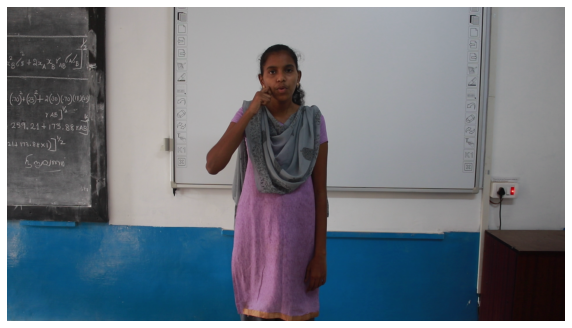

In [8]:
vdos1=[]
vdos1.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/77. Boy/MVI_8644.MP4'))
vdos1.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_4985.MOV'))
vdos1.append(VideoReaderNP('/kaggle/input/include-left/People_4of5/People/78. Girl/MVI_5136.MOV'))
vdos1.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3335.MOV'))
vdos1.append(VideoReaderNP('/kaggle/input/include/Places_4of4/Places/35. Bank/MVI_3581.MOV'))
test_vdo = '/kaggle/input/include/Adjectives_6of8/Adjectives/87. hot/MVI_5138.MOV'
test_image = vdos1[0][16]#extract a frame
import matplotlib.pyplot as plt
# image = plt.imread(test_image) 
#imread will take filename as a string
plt.figure(figsize=(10,10))
plt.imshow(test_image)
plt.axis('off')
plt.show()